<a href="https://colab.research.google.com/github/AlexandreMaestroni/AlexandreMaestroni.github.io/blob/master/smooth4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

"""
smoothness.py contains a list of functions for estimating movement smoothness.
"""
import numpy as np


In [68]:
def sparc(movement, fs, padlevel=4, fc=10.0, amp_th=0.05):
    """
    Calcualtes the smoothness of the given speed profile using the modified
    spectral arc length metric.

    Parameters
    ----------
    movement : np.array
               The array containing the movement speed profile.
    fs       : float
               The sampling frequency of the data.
    padlevel : integer, optional
               Indicates the amount of zero padding to be done to the movement
               data for estimating the spectral arc length. [default = 4]
    fc       : float, optional
               The max. cut off frequency for calculating the spectral arc
               length metric. [default = 10.]
    amp_th   : float, optional
               The amplitude threshold to used for determing the cut off
               frequency upto which the spectral arc length is to be estimated.
               [default = 0.05]

    Returns
    -------
    sal      : float
               The spectral arc length estimate of the given movement's
               smoothness.
    (f, Mf)  : tuple of two np.arrays
               This is the frequency(f) and the magntiude spectrum(Mf) of the
               given movement data. This spectral is from 0. to fs/2.
    (f_sel, Mf_sel) : tuple of two np.arrays
                      This is the portion of the spectrum that is selected for
                      calculating the spectral arc length.

    Notes
    -----
    This is the modfieid spectral arc length metric, which has been tested only
    for discrete movements.

    Examples
    --------
    >>> t = np.arange(-1, 1, 0.01)
    >>> move = np.exp(-5*pow(t, 2))
    >>> sal, _, _ = sparc(move, fs=100.)
    >>> '%.5f' % sal
    '-1.41403'

    """
    try:
        # Number of zeros to be padded.
        nfft = int(pow(2, np.ceil(np.log2(len(movement))) + padlevel))

        # Frequency
        f = np.arange(0, fs, fs / nfft)
        # Normalized magnitude spectrum
        Mf = abs(np.fft.fft(movement, nfft))
        Mf = Mf / max(Mf)

        # Indices to choose only the spectrum within the given cut off
        # frequency Fc.
        # NOTE: This is a low pass filtering operation to get rid of high
        # frequency noise from affecting the next step (amplitude threshold
        # based cut off for  arc length calculation).
        fc_inx = ((f <= fc) * 1).nonzero()
        f_sel = f[fc_inx]
        Mf_sel = Mf[fc_inx]

        # Choose the amplitude threshold based cut off frequency.
        # Index of the last point on the magnitude spectrum that is greater
        # than or equal to the amplitude threshold.
        inx = ((Mf_sel >= amp_th) * 1).nonzero()[0]
        fc_inx = range(inx[0], inx[-1] + 1)
        f_sel = f_sel[fc_inx]
        Mf_sel = Mf_sel[fc_inx]

        # Calculate arc length
        new_sal = -sum(
            np.sqrt(pow(np.diff(f_sel) / (f_sel[-1] - f_sel[0]), 2) +
                    pow(np.diff(Mf_sel), 2)))
        return new_sal
    except:
        return np.NaN, np.NaN, np.NaN

In [3]:
def dimensionless_jerk_factors(movement, fs, data_type='vel', rem_mean=False):
    """
    Returns the individual factors of the dimensionless jerk metric.

    Parameters
    ----------
    movement    : np.array
                  The array containing the movement velocity (acceleration or
                  jerk) profile. This can be multi-dimensional with the rows
                  corresponding to the time samples and the columns
                  corresponding to the different dimensions.
    fs          : float
                  The sampling frequency of the data.
    data_type   : string
                  The type of movement data provided. This will determine the
                  scaling factor to be used. There are only three possibiliies,
                  {'vel', 'accl'}, corresponding to velocity, and acceleration.
    rem_mean    : booleans
                  This indicates if the mean of the given movement data must be
                  removed before comupting the jerk. It must be noted that when
                  the movement data is velocity, this parameter is ignored.
                  This parameter is used only when the movement data is 
                  acceleration or jerk.

    Returns
    -------
    T^N      : float
               Duration scaling factor.
    A^M      : float
               Amplitude scaling factor.
    J        : float
               Jerk cost.

    Notes
    -----


    Examples
    --------
    """
    # Pamameter definition for different data types
    param = {'vel': {'n': 2, 'N': 3},
             'accl': {'n': 1, 'N': 1}}

    n, N = (param[data_type]['n'], param[data_type]['N'])

    # make sure data_type makes sense.
    if data_type not in ('vel', 'accl'):
        _str = '\n'.join(("data_type has to be ('vel', 'accl')!",
                          "{0} provided is not valid".format(data_type)))
        raise Exception(_str)
        return
    
    # first enforce data into an numpy array.
    movement = np.array(movement)
    r, c = np.shape(movement)
    if r < 3:
        _str = '\n'.join(
            ("Data is too short to calcalate jerk! Data must",
             "have at least 3 samples ({0} given).".format(r)))
        raise Exception(_str)
        return

    dt = 1. / fs

    # Remove the mean if the movement dat is acceleration?
    if data_type == 'accl' and rem_mean == True:
        movement = movement - np.mean(movement, axis=0)

    # jerk
    jerk = np.linalg.norm(np.diff(movement, axis=0, n=n), axis=1)
    jerk /= np.power(dt, n)
    mjerk = np.sum(np.power(jerk, 2)) * dt

    # time.
    _N = len(movement)
    mdur = np.power(_N * dt, N)

    # amplitude.
    mamp = np.power(np.max(np.linalg.norm(movement, axis=1)), 2)

    # dlj factors
    return mdur, mamp, mjerk

In [4]:
def dimensionless_jerk(movement, fs, data_type='vel', rem_mean=False):
    """
    Calculates the smoothness metric for the given velocity profile using the
    dimensionless jerk metric.

    Parameters
    ----------
    movement    : np.array
                  The array containing the movement velocity (acceleration or
                  jerk) profile. This can be multi-dimensional with the rows
                  corresponding to the time samples and the columns
                  corresponding to the different dimensions.
    fs          : float
                  The sampling frequency of the data.
    data_type   : string
                  The type of movement data provided. This will determine the
                  scaling factor to be used. There are only three possibiliies,
                  {'vel', 'accl'}, corresponding to velocity, and acceleration.
    rem_mean    : booleans
                  This indicates if the mean of the given movement data must be
                  removed before comupting the jerk. It must be noted that when
                  the movement data is velocity, this parameter is ignored.
                  This parameter is used only when the movement data is 
                  acceleration or jerk.

    Returns
    -------
    dl       : float
               The dimensionless jerk estimate of the given movement's
               smoothness.

    Notes
    -----


    Examples
    --------
    >>> t = np.arange(-1, 1, 0.01)
    >>> move = np.exp(-5*pow(t, 2))
    >>> dl = dimensionless_jerk(np.array([move]).T, fs=100.)
    >>> '%.5f' % dl
    '-335.74684'
    >>> dl = dimensionless_jerk(np.array([move, move, move]).T, fs=100.)
    >>> '%.5f' % dl
    '-335.74684'

    """
    # Factors for dimensionless jer
    dljfac = dimensionless_jerk_factors(movement, fs, data_type, rem_mean)

    # estimate dj
    return - (dljfac[0] / dljfac[1]) * dljfac[2]


In [5]:
def log_dimensionless_jerk_factors(movement, fs, data_type='vel',
                                   rem_mean=False):
    """
    Returns the individual factors of the dimensionless jerk metric.

    Parameters
    ----------
    movement    : np.array
                  The array containing the movement velocity (acceleration or
                  jerk) profile. This can be multi-dimensional with the rows
                  corresponding to the time samples and the columns
                  corresponding to the different dimensions.
    fs          : float
                  The sampling frequency of the data.
    data_type   : string
                  The type of movement data provided. This will determine the
                  scaling factor to be used. There are only three possibiliies,
                  {'vel', 'accl'}, corresponding to velocity, and acceleration.
    rem_mean    : booleans
                  This indicates if the mean of the given movement data must be
                  removed before comupting the jerk. It must be noted that when
                  the movement data is velocity, this parameter is ignored.
                  This parameter is used only when the movement data is 
                  acceleration or jerk.
    Returns
    -------
    -ln(T^N) : float
               Duration scaling factor.
    +ln(A^M) : float
               Amplitude scaling factor.
    -ln(J)   : float
               Jerk cost.

    Notes
    -----


    Examples
    --------
    """
    dljfac = dimensionless_jerk_factors(movement, fs, data_type, rem_mean)
    return - np.log(dljfac[0]), np.log(dljfac[1]), - np.log(dljfac[2])



In [6]:
def log_dimensionless_jerk(movement, fs, data_type='vel',
                           rem_mean=False):
    """
    Calculates the smoothness metric for the given movement velocity,
    acceleration or jerk profile using the log dimensionless jerk metric.

    Parameters
    ----------
    movement    : np.array
                  The array containing the movement velocity (acceleration or
                  jerk) profile. This can be multi-dimensional with the rows
                  corresponding to the time samples and the columns
                  corresponding to the different dimensions.
    fs          : float
                  The sampling frequency of the data.
    data_type   : string
                  The type of movement data provided. This will determine the
                  scaling factor to be used. There are only three possibiliies,
                  {'vel', 'accl'}, corresponding to velocity, and acceleration.
    rem_mean    : booleans
                  This indicates if the mean of the given movement data must be
                  removed before comupting the jerk. It must be noted that when
                  the movement data is velocity, this parameter is ignored.
                  This parameter is used only when the movement data is 
                  acceleration or jerk.

    Returns
    -------
    ldlj      : float
               The log dimensionless jerk estimate of the given movement's
               smoothness.

    Notes
    -----


    Examples
    --------
    >>> t = np.arange(-1, 1, 0.01)
    >>> move = np.exp(-5*pow(t, 2))
    >>> dl = log_dimensionless_jerk(np.array([move]).T, fs=100.)
    >>> '%.5f' % ldl
    '-5.81636'
    >>> dl = log_dimensionless_jerk(np.array([move, move, move]).T, fs=100.)
    >>> '%.5f' % ldl
    '-5.81636'

    """
    ldljfac = log_dimensionless_jerk_factors(movement, fs, data_type, rem_mean)
    return ldljfac[0] + ldljfac[1] + ldljfac[2]

In [32]:
  # Read the CSV file
  filenameACC = f'MouvementACCRA310{i+1:02d}.csv'
  ACC = pd.read_csv(filenameACC, delimiter=',')
  ACC_head=ACC.head()
  print(ACC_head)
  # Extract the AV column
  MocapACx = ACC.iloc[:, 1]
  MocapACy = ACC.iloc[:, 2]
  MocapACz = ACC.iloc[:, 3]
  # Extract the AC column
  IMUACx = ACC.iloc[:, 5]
  IMUACy = ACC.iloc[:, 6]
  IMUACz = ACC.iloc[:, 7]
  # Find fs
  MocapACt = ACC.iloc[:,0]
  IMUACt = ACC.iloc[:,4]
  MocapACT = MocapACt[len(MocapACt)-1] - MocapACt[0]
  IMUACT = IMUACt[len(IMUACt)-1] - IMUACt[0]
  ACTs = max(MocapACT,IMUACT)
  ACfs = 1/ACTs

   0.804881299019608  0.00278140727965139  -0.000103915280489352  \
0           0.818382             0.000350               0.000894   
1           0.831883             0.004285               0.004512   
2           0.845384            -0.002706              -0.004683   
3           0.858885            -0.007777              -0.001791   
4           0.872385            -0.019834              -0.009425   

   0.00891056885063229  0.7965  0.194135469382852  0.23450663981887  \
0            -0.004125  0.8100           0.552822          0.668345   
1             0.001356  0.8235           0.657836          0.796919   
2            -0.005700  0.8370           0.576188          0.703255   
3            -0.004758  0.8505           0.565404          0.698097   
4            -0.009048  0.8640           0.576899          0.717490   

   0.0707701921115447  
0            0.201747  
1            0.239372  
2            0.207210  
3            0.202788  
4            0.210017  


In [19]:
  # Read the CSV file
  AV = pd.read_csv('MouvementAVRA31001.csv', delimiter=',')
  AV_head=AV.head()
  print(AV_head)
  # Extract the AV column
  MocapAVx = AV.iloc[:, 1]
  MocapAVy = AV.iloc[:, 2]
  MocapAVz = AV.iloc[:, 3]
  # Extract the AV column
  IMUAVx = AV.iloc[:, 5]
  IMUAVy = AV.iloc[:, 6]
  IMUAVz = AV.iloc[:, 7]
  # Find fs
  MocapAVt = AV.iloc[:,0]
  IMUAVt = AV.iloc[:,4]
  MocapAVT = MocapAVt[len(MocapAVt)-1] - MocapAVt[0]
  IMUAVT = IMUAVt[len(IMUAVt)-1] - IMUAVt[0]
  AVTs = max(MocapAVT,IMUAVT)
  AVfs = 1/AVTs

   0  -1.67966204461353  0.834366954839402  -1.02241579607528  0.7965  \
0  0          -2.546881           1.293384          -0.884467  0.8100   
1  0          -2.605778           1.061995          -0.415962  0.8235   
2  0          -1.867214           2.158310          -1.038723  0.8370   
3  0          -3.107384           1.253761          -3.919452  0.8505   
4  0          -2.813552           2.974921          -3.961073  0.8640   

   4.72010451648218  4.84061660379402  0.803421821084286  
0         13.648619         13.852392           2.275733  
1         16.912809         16.922934           2.708610  
2         15.647137         15.810865           2.449310  
3         15.295843         15.893404           2.470680  
4         14.965019         15.132416           2.452799  


In [18]:
  log_dimensionless_jerk([IMUACx,IMUACy,IMUACz],1/5.508,'accl',False)

-0.730455743841989

In [19]:
  log_dimensionless_jerk([MocapACx,MocapACy,MocapACz],1/5.508,'accl',False)

-1.8440809385367771

In [20]:
  log_dimensionless_jerk([IMUAVx,IMUAVy,IMUAVz],AVfs,'vel',False)

-3.8269447769136375

In [21]:
  log_dimensionless_jerk([MocapAVx,MocapAVy,MocapAVz],AVfs,'vel',False)

-4.595454752199782

In [82]:
import zipfile

zip_file_path = "M.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("")

In [84]:
import pandas as pd
import numpy as np

IMU_LDLJA_RH = []
Mocap_LDLJA_RH =[]
IMU_LDLJV_RH = []
Mocap_LDLJV_RH =[]
IMU_SPARC_RH = []
Mocap_SPARC_RH =[]

IMU_LDLJA_LH = []
Mocap_LDLJA_LH =[]
IMU_LDLJV_LH = []
Mocap_LDLJV_LH =[]
IMU_SPARC_LH = []
Mocap_SPARC_LH =[]

IMU_LDLJA_RA = []
Mocap_LDLJA_RA =[]
IMU_LDLJV_RA = []
Mocap_LDLJV_RA =[]
IMU_SPARC_RA = []
Mocap_SPARC_RA =[]

IMU_LDLJA_LA = []
Mocap_LDLJA_LA =[]
IMU_LDLJV_LA = []
Mocap_LDLJV_LA =[]
IMU_SPARC_LA = []
Mocap_SPARC_LA =[]

IMU_LDLJA_ST = []
Mocap_LDLJA_ST =[]
IMU_LDLJV_ST = []
Mocap_LDLJV_ST =[]
IMU_SPARC_ST = []
Mocap_SPARC_ST =[]

for i in range (62):
  for j in range (5):
    # Read the CSV file
    if j == 0 :#RH1
      filenameACC = f'M/RHAcc/MouvementACCRH310{i+1:02d}.csv'
    if j == 1 :#LH2
      filenameACC = f'M/LHAcc/MouvementACCLH310{i+1:02d}.csv'
    if j == 2 :#RA3
      filenameACC = f'M/RAAcc/MouvementACCRA310{i+1:02d}.csv'
    if j == 3 :#LA4
      filenameACC = f'M/LAAcc/MouvementACCLA310{i+1:02d}.csv'
    if j == 4 :#ST5
      filenameACC = f'M/STAcc/MouvementACCST310{i+1:02d}.csv'
    ACC = pd.read_csv(filenameACC, delimiter=',')

    # Extract the AV column
    MocapACx = ACC.iloc[:, 1]
    MocapACy = ACC.iloc[:, 2]
    MocapACz = ACC.iloc[:, 3]
    # Extract the AC column
    IMUACx = ACC.iloc[:, 5]
    IMUACy = ACC.iloc[:, 6]
    IMUACz = ACC.iloc[:, 7]
    # Find fs
    MocapACt = ACC.iloc[:,0]
    IMUACt = ACC.iloc[:,4]
    MocapACT = MocapACt[len(MocapACt)-1] - MocapACt[0]
    IMUACT = IMUACt[len(IMUACt)-1] - IMUACt[0]
    ACTs = max(MocapACT,IMUACT)
    ACfs = 1/ACTs
    # Read the CSV file
    if j == 0 :#RH1
      filenameAV = f'M/RHAV/MouvementAVRH310{i+1:02d}.csv'
    if j == 1 :#LH2
      filenameAV = f'M/LHAV/MouvementAVLH310{i+1:02d}.csv'
    if j == 2 :#RA3
      filenameAV = f'M/RAAV/MouvementAVRA310{i+1:02d}.csv'
    if j == 3 :#LA4
      filenameAV = f'M/LAAV/MouvementAVLA310{i+1:02d}.csv'
    if j == 4 :#ST5
      filenameAV = f'M/STAV/MouvementAVST310{i+1:02d}.csv'
    AV = pd.read_csv(filenameAV, delimiter=',')
    # Extract the AV column
    MocapAVx = AV.iloc[:, 1]
    MocapAVy = AV.iloc[:, 2]
    MocapAVz = AV.iloc[:, 3]
    MocapAVmag = np.sqrt(np.square(MocapAVx) + np.square(MocapAVy) + np.square(MocapAVz))
    # Extract the AV column
    IMUAVx = AV.iloc[:, 5]
    IMUAVy = AV.iloc[:, 6]
    IMUAVz = AV.iloc[:, 7]
    IMUAVmag = np.sqrt(np.square(IMUAVx) + np.square(IMUAVy) + np.square(IMUAVz))
    # Find fs
    MocapAVt = AV.iloc[:,0]
    IMUAVt = AV.iloc[:,4]
    MocapAVT = MocapAVt[len(MocapAVt)-1] - MocapAVt[0]
    IMUAVT = IMUAVt[len(IMUAVt)-1] - IMUAVt[0]
    AVTs = max(MocapAVT,IMUAVT)
    AVfs = 1/AVTs
    value_IMU_LDLJA = log_dimensionless_jerk([IMUACx,IMUACy,IMUACz],ACfs,'accl',False)
    value_Mocap_LDLJA = log_dimensionless_jerk([MocapACx,MocapACy,MocapACz],ACfs,'accl',False)
    value_IMU_LDLJV = log_dimensionless_jerk([IMUAVx,IMUAVy,IMUAVz],AVfs,'vel',False)
    value_Mocap_LDLJV = log_dimensionless_jerk([MocapAVx,MocapAVy,MocapAVz],AVfs,'vel',False)
    value_IMU_SPARC = sparc(IMUAVmag,AVfs,4,10,0.05)
    value_Mocap_SPARC = sparc(MocapAVmag,AVfs,4,10,0.05)
    if j == 0 :#RH1
      IMU_LDLJA_RH.append(value_IMU_LDLJA)
      Mocap_LDLJA_RH.append(value_Mocap_LDLJA)
      IMU_LDLJV_RH.append(value_IMU_LDLJV)
      Mocap_LDLJV_RH.append(value_Mocap_LDLJV)
      IMU_SPARC_RH.append(value_IMU_SPARC)
      Mocap_SPARC_RH.append(value_Mocap_SPARC)
    if j == 1 :#LH2
      IMU_LDLJA_LH.append(value_IMU_LDLJA)
      Mocap_LDLJA_LH.append(value_Mocap_LDLJA)
      IMU_LDLJV_LH.append(value_IMU_LDLJV)
      Mocap_LDLJV_LH.append(value_Mocap_LDLJV)
      IMU_SPARC_LH.append(value_IMU_SPARC)
      Mocap_SPARC_LH.append(value_Mocap_SPARC)
    if j == 2 :#RA3
      IMU_LDLJA_RA.append(value_IMU_LDLJA)
      Mocap_LDLJA_RA.append(value_Mocap_LDLJA)
      IMU_LDLJV_RA.append(value_IMU_LDLJV)
      Mocap_LDLJV_RA.append(value_Mocap_LDLJV)
      IMU_SPARC_RA.append(value_IMU_SPARC)
      Mocap_SPARC_RA.append(value_Mocap_SPARC)
    if j == 3 :#LA4
      IMU_LDLJA_LA.append(value_IMU_LDLJA)
      Mocap_LDLJA_LA.append(value_Mocap_LDLJA)
      IMU_LDLJV_LA.append(value_IMU_LDLJV)
      Mocap_LDLJV_LA.append(value_Mocap_LDLJV)
      IMU_SPARC_LA.append(value_IMU_SPARC)
      Mocap_SPARC_LA.append(value_Mocap_SPARC)
    if j == 4 :#ST5
      IMU_LDLJA_ST.append(value_IMU_LDLJA)
      Mocap_LDLJA_ST.append(value_Mocap_LDLJA)
      IMU_LDLJV_ST.append(value_IMU_LDLJV)
      Mocap_LDLJV_ST.append(value_Mocap_LDLJV)
      IMU_SPARC_ST.append(value_IMU_SPARC)
      Mocap_SPARC_ST.append(value_Mocap_SPARC)

In [85]:
print(IMU_SPARC_RH)

[-8.482686416775568, -9.084550050488293, -8.077603349511062, -7.5166088144544405, -8.103312188404622, -8.431961323393521, -8.322021885950878, -7.755990431779383, -7.901839538034199, -8.331860704533781, -8.07765606646059, -7.919108903307277, -9.976137600311304, -15.74603676373821, -8.014917563546598, -9.98381111679439, -8.432943297245641, -9.782133756190268, -8.471375179984967, -9.978020970131352, -9.809927500122889, -9.75090978106027, -8.217658846015695, -8.761086843939484, -8.01216533114193, -8.718208161838879, -8.733347627679745, -9.517937180917125, -10.057443852243976, -8.641498491315941, -7.766978397578801, -7.960722266414308, -7.722295173042321, -6.132771078028665, -7.543756152206812, -5.748476859975378, -9.202166238113186, -7.201852037800753, -17.483058636482344, -27.251996414080587, -19.071193306565046, -28.286310645412154, -8.713736831974256, -8.578714868602383, -8.14821264799638, -7.873637126874847, -8.169158928734287, -9.179047518905266, -9.793149968789342, -8.020958576199373

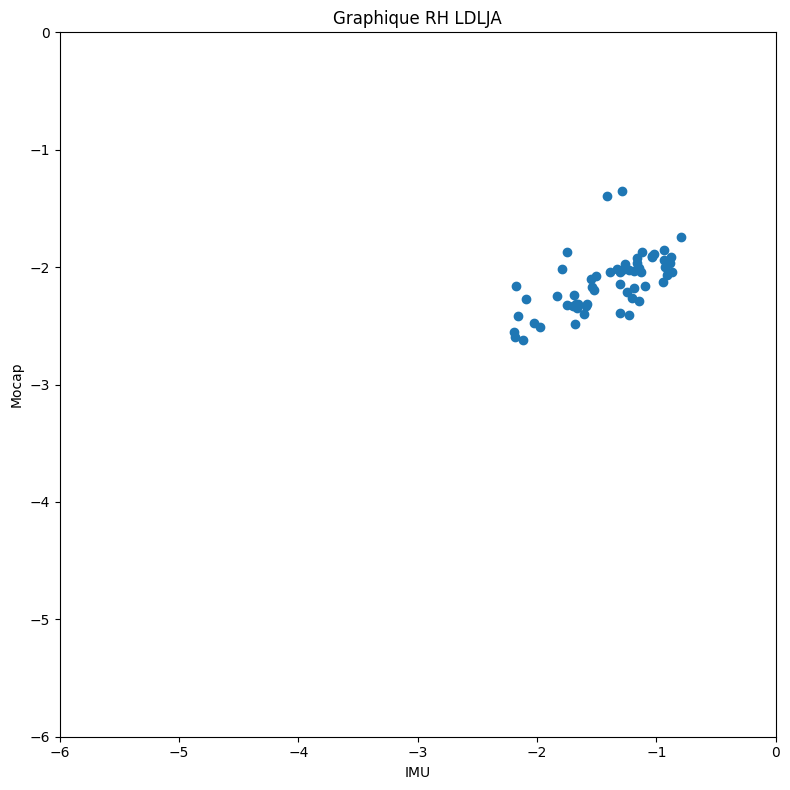

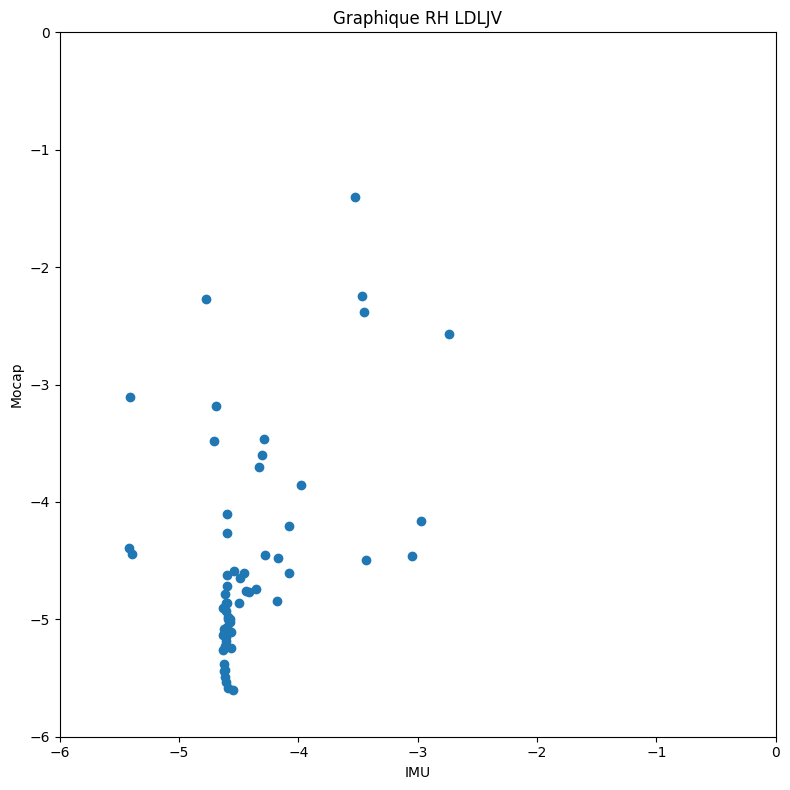

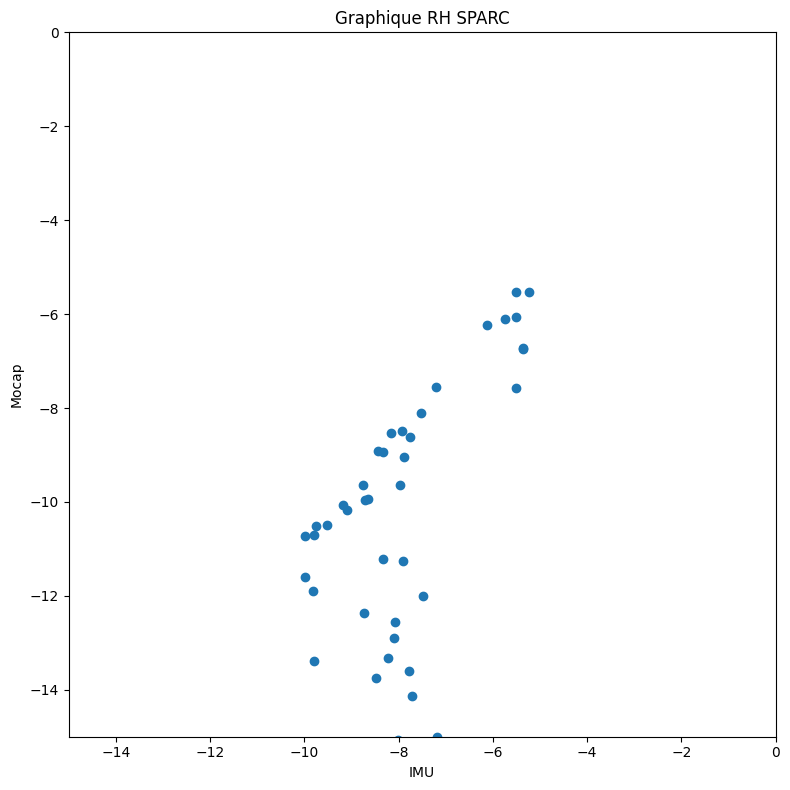

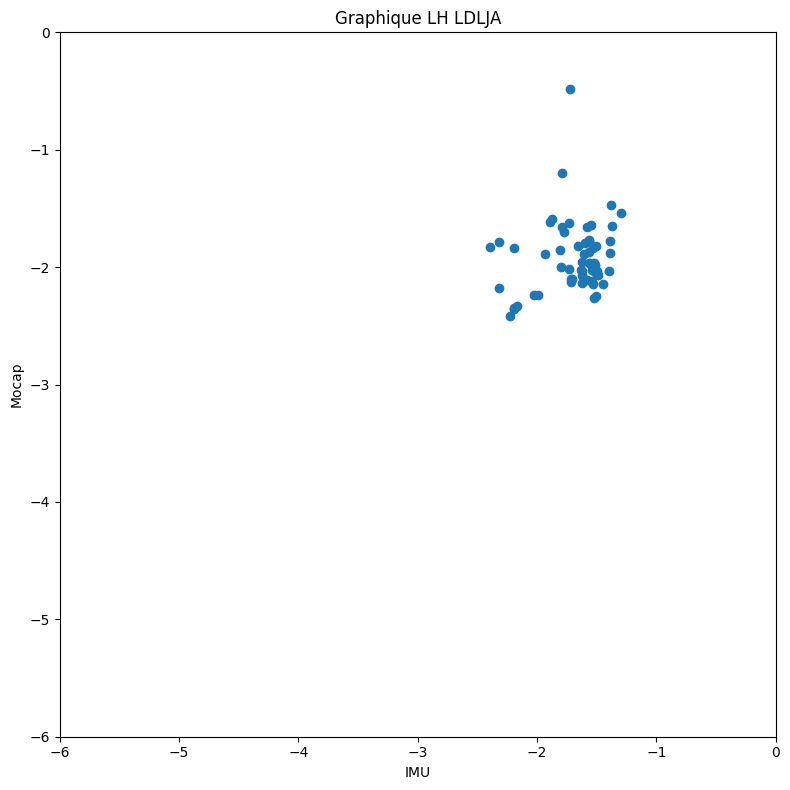

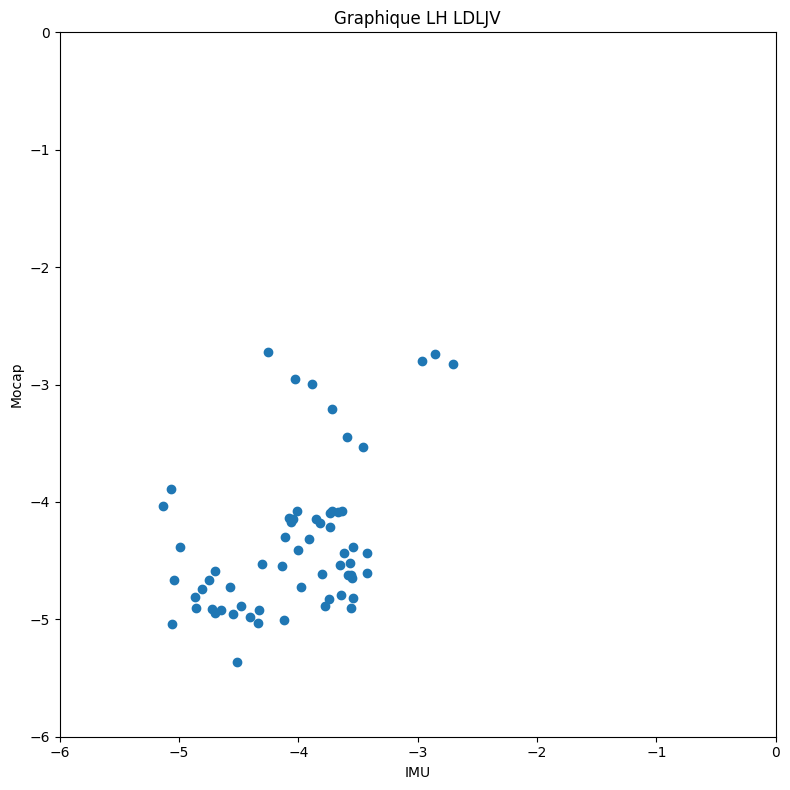

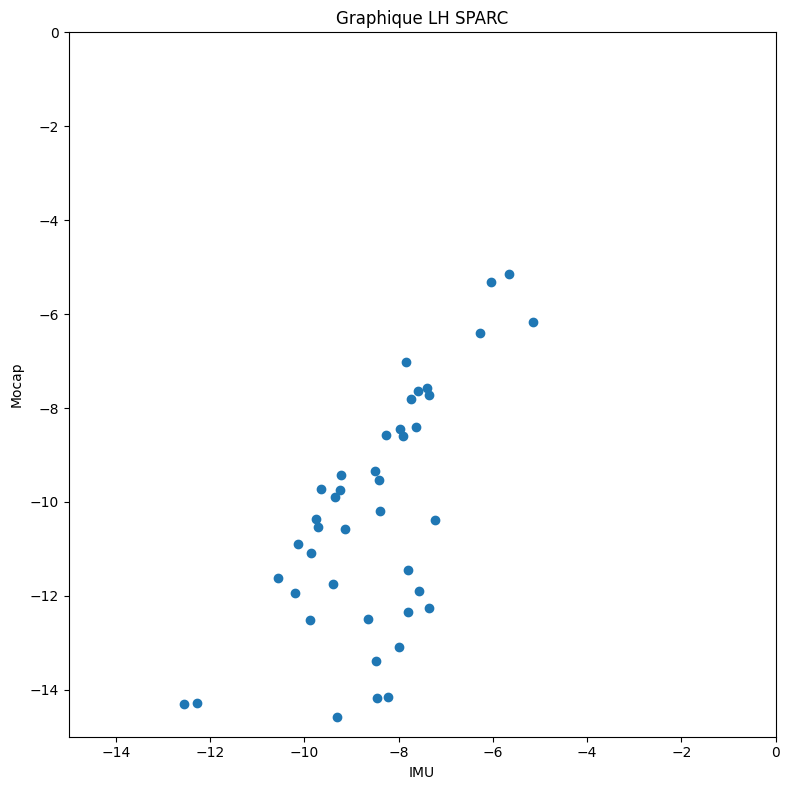

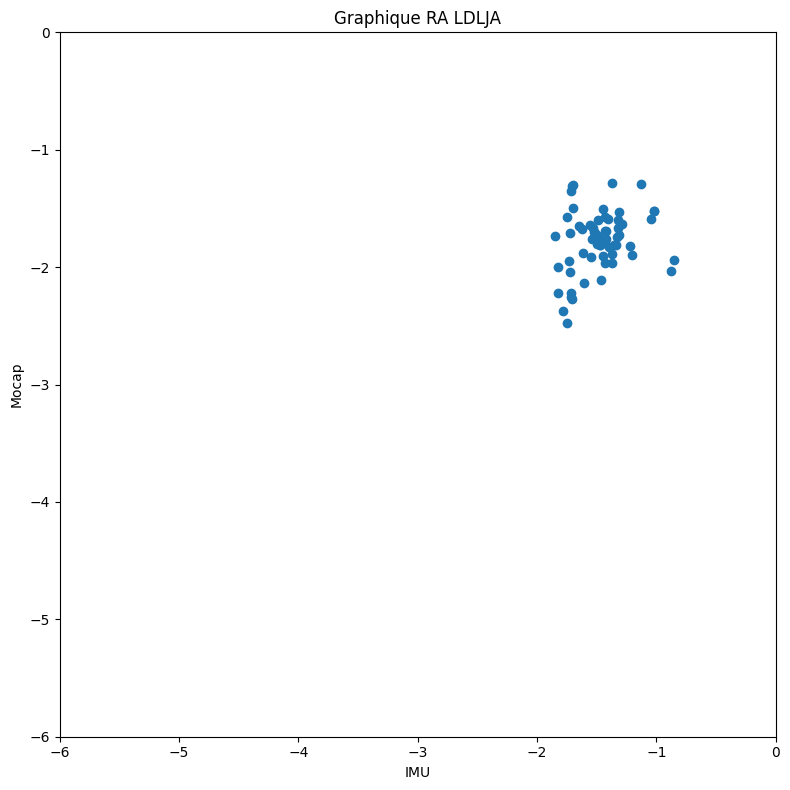

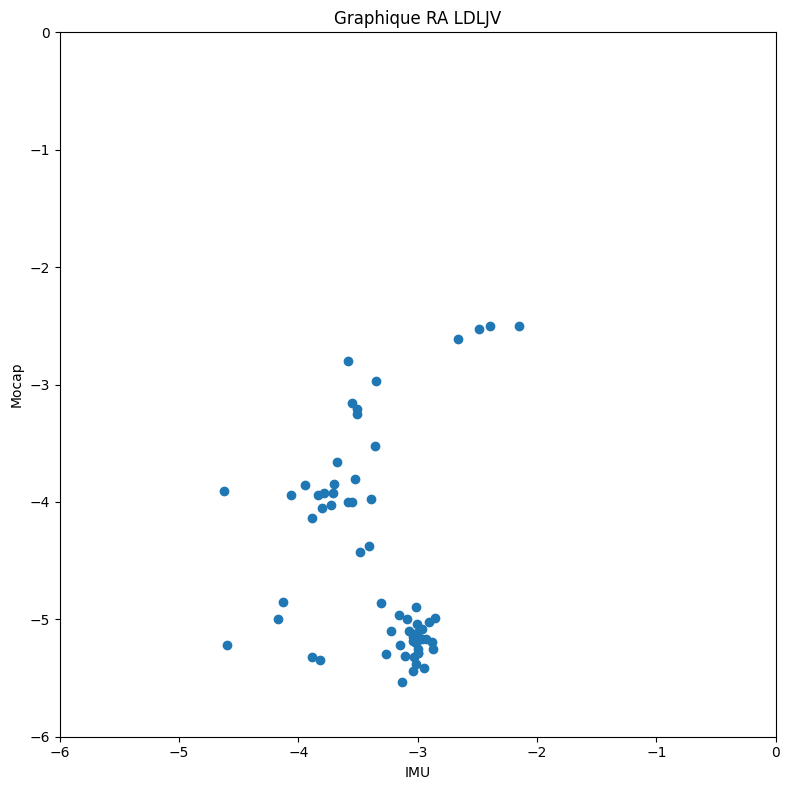

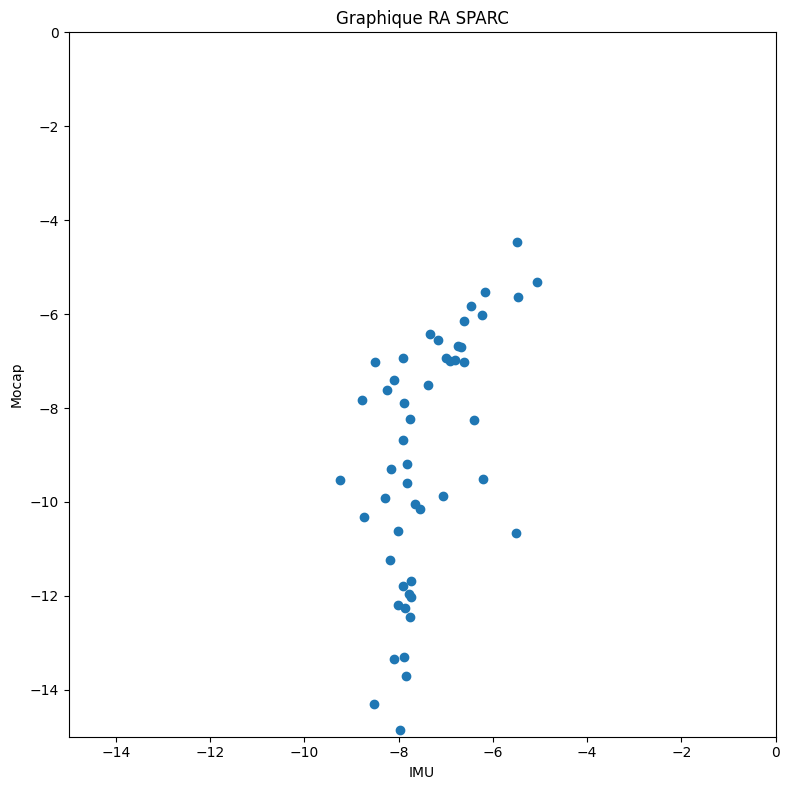

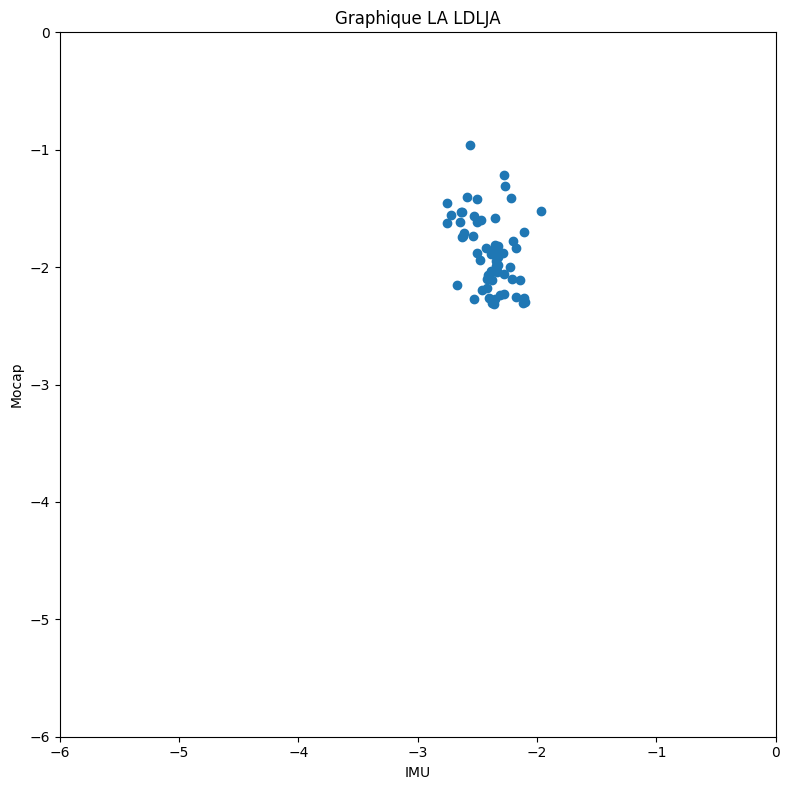

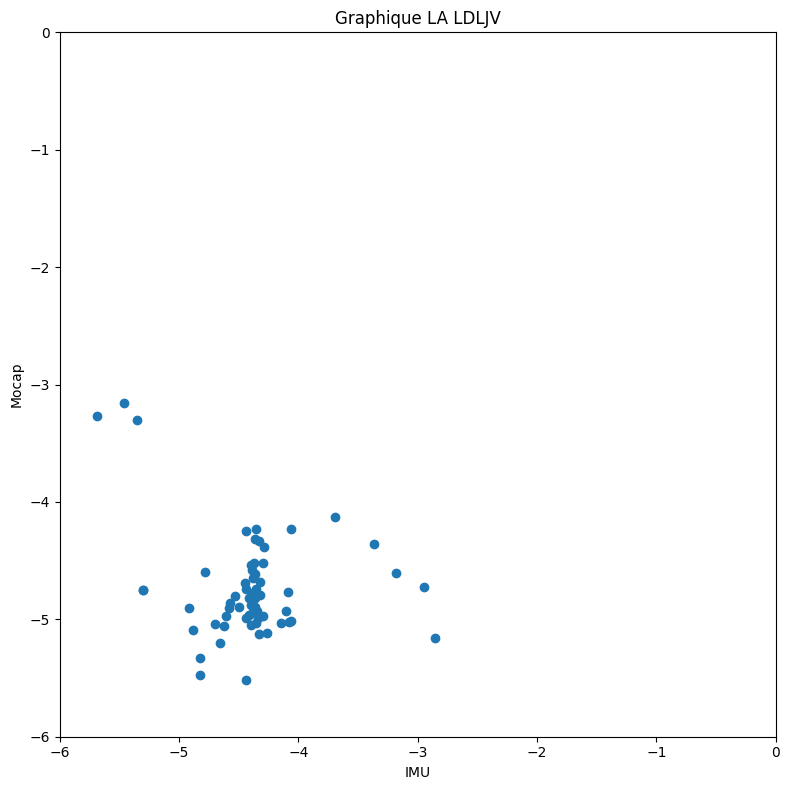

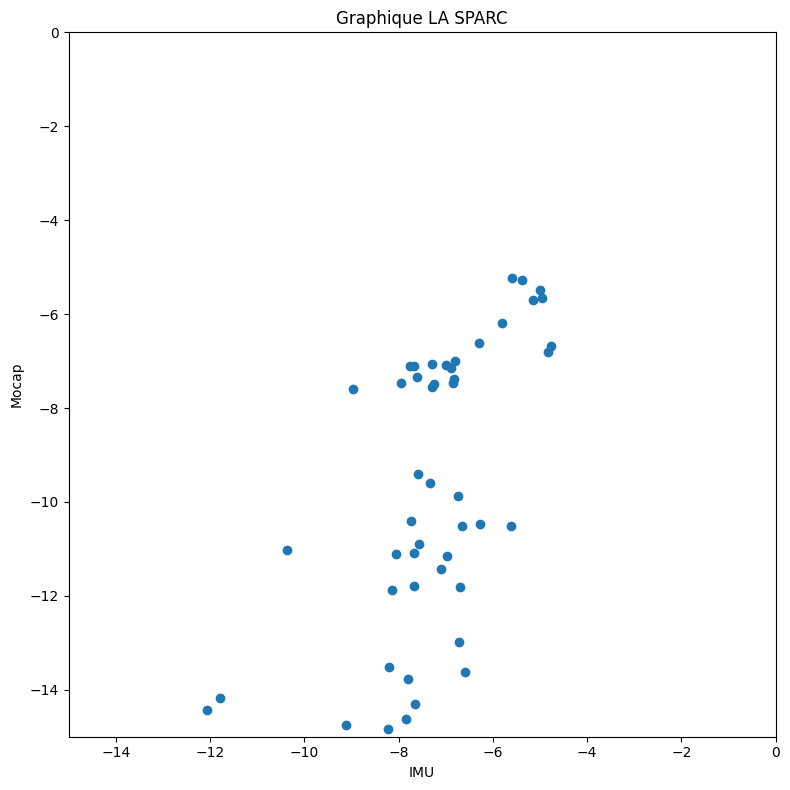

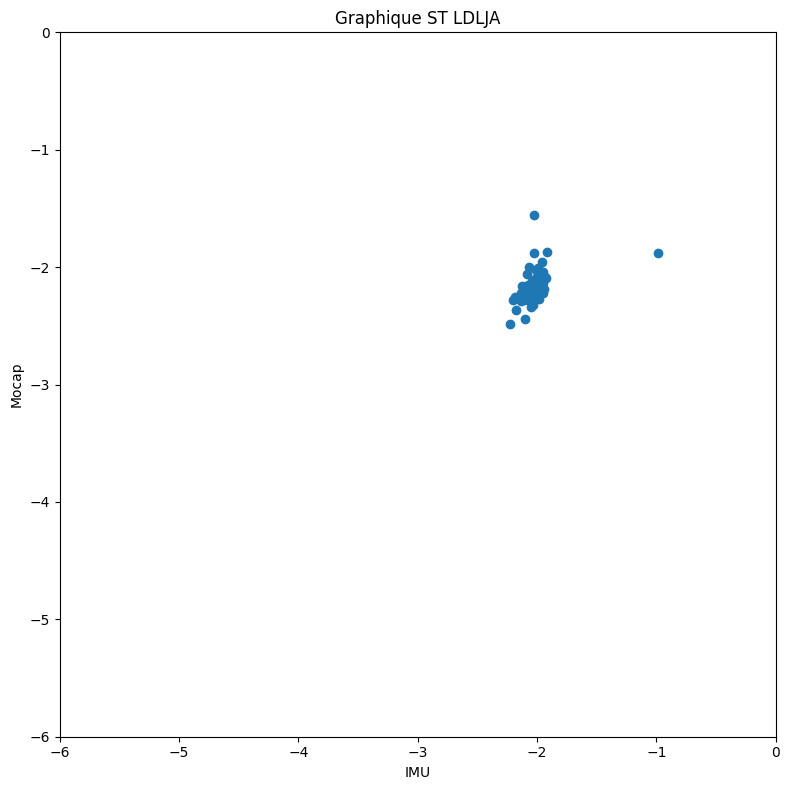

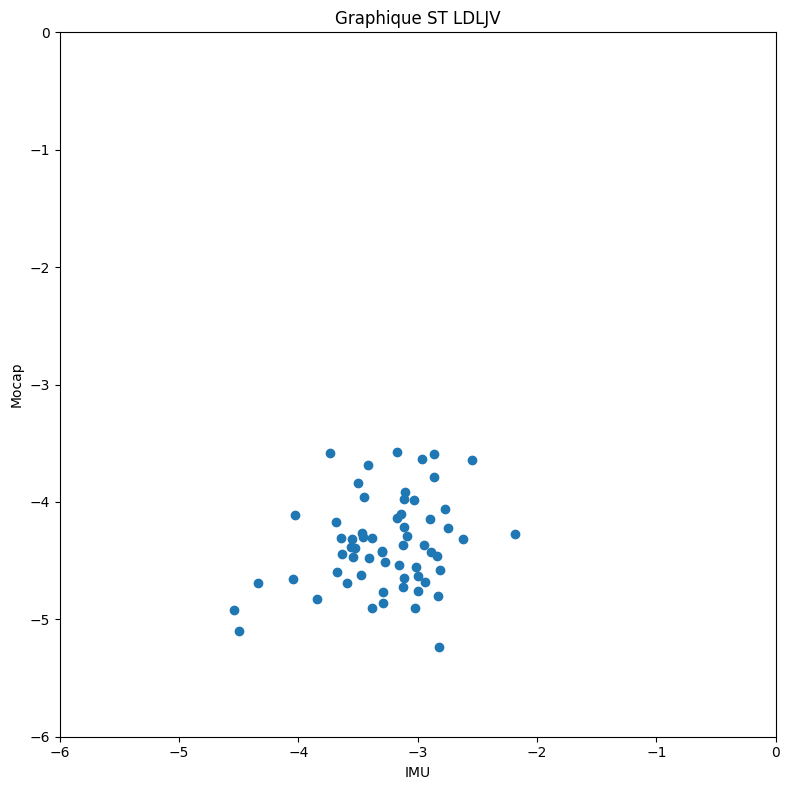

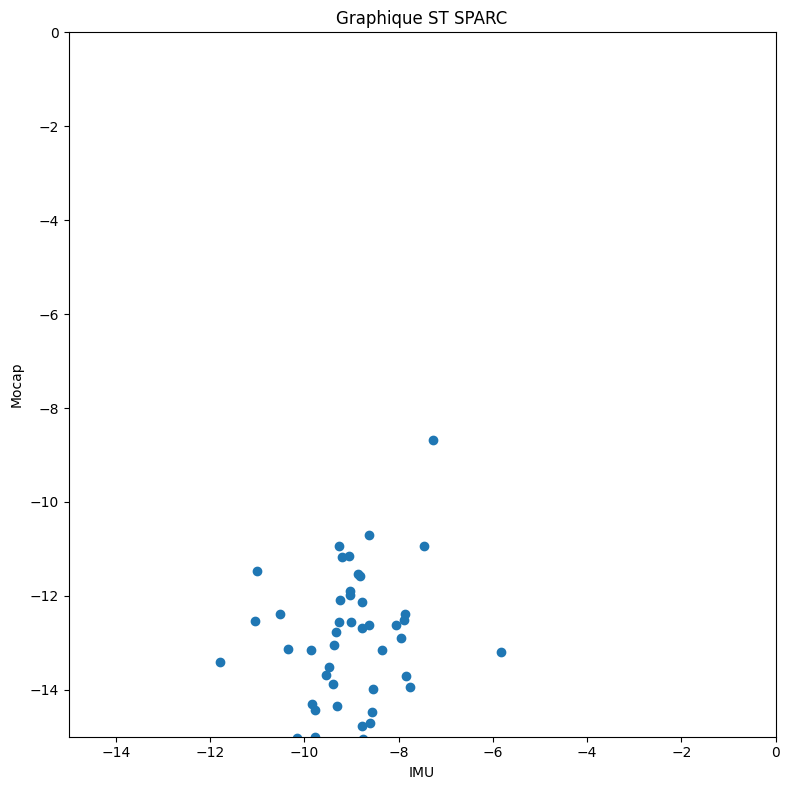

In [86]:
import matplotlib.pyplot as plt
# Création des sous-graphiques
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax1.scatter(IMU_LDLJA_RH, Mocap_LDLJA_RH, label='LDLJA')
ax1.set_xlim(-6, 0)
ax1.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax1.set_xlabel('IMU')
ax1.set_ylabel('Mocap')
ax1.set_title('Graphique RH LDLJA')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax2.scatter(IMU_LDLJV_RH, Mocap_LDLJV_RH, label='LDLJV')
ax2.set_xlim(-6, 0)
ax2.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax2.set_xlabel('IMU')
ax2.set_ylabel('Mocap')
ax2.set_title('Graphique RH LDLJV')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()
# Création des sous-graphiques
fig, (ax3) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax3.scatter(IMU_SPARC_RH, Mocap_SPARC_RH, label='SPARC')
ax3.set_xlim(-15, 0)
ax3.set_ylim(-15, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax3.set_xlabel('IMU')
ax3.set_ylabel('Mocap')
ax3.set_title('Graphique RH SPARC')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax4) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax4.scatter(IMU_LDLJA_LH, Mocap_LDLJA_LH, label='LDLJA')
ax4.set_xlim(-6, 0)
ax4.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax4.set_xlabel('IMU')
ax4.set_ylabel('Mocap')
ax4.set_title('Graphique LH LDLJA')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()
# Création des sous-graphiques
fig, (ax5) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax5.scatter(IMU_LDLJV_LH, Mocap_LDLJV_LH, label='LDLJV')
ax5.set_xlim(-6, 0)
ax5.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax5.set_xlabel('IMU')
ax5.set_ylabel('Mocap')
ax5.set_title('Graphique LH LDLJV')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax6) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax6.scatter(IMU_SPARC_LH, Mocap_SPARC_LH, label='SPARC')
ax6.set_xlim(-15, 0)
ax6.set_ylim(-15, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax6.set_xlabel('IMU')
ax6.set_ylabel('Mocap')
ax6.set_title('Graphique LH SPARC')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax7) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax7.scatter(IMU_LDLJA_RA, Mocap_LDLJA_RA, label='LDLJA')
ax7.set_xlim(-6, 0)
ax7.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax7.set_xlabel('IMU')
ax7.set_ylabel('Mocap')
ax7.set_title('Graphique RA LDLJA')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax8) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax8.scatter(IMU_LDLJV_RA, Mocap_LDLJV_RA, label='LDLJV')
ax8.set_xlim(-6, 0)
ax8.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax8.set_xlabel('IMU')
ax8.set_ylabel('Mocap')
ax8.set_title('Graphique RA LDLJV')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax9) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax9.scatter(IMU_SPARC_RA, Mocap_SPARC_RA, label='SPARC')
ax9.set_xlim(-15, 0)
ax9.set_ylim(-15, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax9.set_xlabel('IMU')
ax9.set_ylabel('Mocap')
ax9.set_title('Graphique RA SPARC')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax10) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax10.scatter(IMU_LDLJA_LA, Mocap_LDLJA_LA, label='LDLJA')
ax10.set_xlim(-6, 0)
ax10.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax10.set_xlabel('IMU')
ax10.set_ylabel('Mocap')
ax10.set_title('Graphique LA LDLJA')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax11) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax11.scatter(IMU_LDLJV_LA, Mocap_LDLJV_LA, label='LDLJV')
ax11.set_xlim(-6, 0)
ax11.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax11.set_xlabel('IMU')
ax11.set_ylabel('Mocap')
ax11.set_title('Graphique LA LDLJV')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax12) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax12.scatter(IMU_SPARC_LA, Mocap_SPARC_LA, label='SPARC')
ax12.set_xlim(-15, 0)
ax12.set_ylim(-15, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax12.set_xlabel('IMU')
ax12.set_ylabel('Mocap')
ax12.set_title('Graphique LA SPARC')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax13) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax13.scatter(IMU_LDLJA_ST, Mocap_LDLJA_ST, label='LDLJA')
ax13.set_xlim(-6, 0)
ax13.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax13.set_xlabel('IMU')
ax13.set_ylabel('Mocap')
ax13.set_title('Graphique ST LDLJA')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax14) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax14.scatter(IMU_LDLJV_ST, Mocap_LDLJV_ST, label='LDLJV')
ax14.set_xlim(-6, 0)
ax14.set_ylim(-6, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax14.set_xlabel('IMU')
ax14.set_ylabel('Mocap')
ax14.set_title('Graphique ST LDLJV')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

# Création des sous-graphiques
fig, (ax15) = plt.subplots(1, 1, figsize=(8, 8))

# Tracer les points sur chaque sous-graphique
ax15.scatter(IMU_SPARC_ST, Mocap_SPARC_ST, label='SPARC')
ax15.set_xlim(-15, 0)
ax15.set_ylim(-15, 0)

# Ajout des légendes et des titres pour chaque sous-graphique
ax15.set_xlabel('IMU')
ax15.set_ylabel('Mocap')
ax15.set_title('Graphique ST SPARC')

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()
